In [1]:
import os
from dotenv import load_dotenv
import numpy as np
import tensorflow as tf
import pandas as pd
import datetime
from tqdm.notebook import tqdm
import warnings
import matplotlib.pyplot as plt

physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
# try:
#   tf.config.experimental.set_memory_growth(physical_devices[0], True)
# except:
#   # Invalid device or cannot modify virtual devices once initialized.
#   pass

load_dotenv(override=True)

DATA_PATH = os.getenv('DATA_PATH')
DATA_PATH_INTERPRO = os.getenv('DATA_PATH_INTERPRO')
print(DATA_PATH)
print(DATA_PATH_INTERPRO)

# Choose subontology (CCO, MFO or BPO)
SO = 'BPO'

2023-08-12 10:47:54.538531: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-12 10:47:54.982632: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Num GPUs Available:  1
/mnt/e/ML/cafa-5-protein-function-prediction
/mnt/e/ML/output


2023-08-12 10:47:55.777080: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-12 10:47:55.796774: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-12 10:47:55.797120: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.


## Reading fasta, obo and tsv files

In [2]:
from Bio import SeqIO

sequences = [rec.seq for rec in SeqIO.parse(os.path.join(DATA_PATH, "Train/train_sequences.fasta"),"fasta")]
ids = [rec.id for rec in SeqIO.parse(os.path.join(DATA_PATH, "Train/train_sequences.fasta"),"fasta")]

In [3]:
import networkx
import obonet

# Read the taxrank ontology
url = os.path.join(DATA_PATH, "Train/go-basic.obo")
graph = obonet.read_obo(url)


In [4]:
df = pd.read_csv(os.path.join(DATA_PATH, "Train/train_terms.tsv"), sep='\t')

dfSO = df.loc[df["aspect"]==SO]
uniqueTerms = dfSO["term"].unique()
termsArr = list(dfSO["term"].to_numpy())

uniqueTermsDict={}
for i,el in enumerate(uniqueTerms):
    uniqueTermsDict[el] = i
    
print(dfSO.shape)
df=dfSO

df.set_index("EntryID", inplace=True)

(3497732, 3)


In [5]:
testID = df.index.to_list()[0]

In [6]:
dfGo = pd.read_csv(os.path.join(DATA_PATH, "Train/train_terms.tsv"), sep='\t')

dfGo = dfGo.loc[dfGo["aspect"]==SO]

dfGo.set_index("term", inplace=True)

## GO analysis

In [7]:
item_counts = df["term"].value_counts()

In [8]:
id_to_name = {id_: data.get('name') for id_, data in graph.nodes(data=True)}
name_to_id = {data['name']: id_ for id_, data in graph.nodes(data=True) if 'name' in data}

In [9]:
if SO=="CCO":
    GOTarget=name_to_id["cellular_component"]
elif SO=="MFO":
    GOTarget=name_to_id["molecular_function"]
elif SO=="BPO":
    GOTarget = name_to_id["biological_process"]

def getAllAncestors(go):
    try:
        paths = networkx.all_simple_paths(
            graph,
            source=go,
            target=GOTarget
        )
    except:
        return []
    gos = []
    for path in paths:
        for node in path:
            gos.append(node)
    return list(set(gos))


## Label encoding

The task is a multilabel classification: The output has several possible targets (Gene Ontologies) but each can only be 1 (existing) or 0 (non existing)

Extract label weights from IA

In [10]:
dfIa = pd.read_csv(os.path.join(DATA_PATH, "IA.txt"), sep='\t', header=None)

dfIa.set_index(0, inplace=True)

labelWeights=[]
allIndices = dfIa.index.tolist()



notFound=0
for go in item_counts.index.to_list():
    if go in allIndices:
        labelWeights.append(dfIa.loc[go].to_numpy()[0])
    else:
        notFound += 1
        labelWeights.append(0)

print("Not found GOs: {} (set to 0)".format(notFound))

Not found GOs: 0 (set to 0)


In [11]:
topGOs=item_counts.index.to_list()

threshold=0
labelWeights=np.array(labelWeights)
selection = labelWeights>threshold
topGOs=np.array(topGOs)[selection]

if os.path.exists(os.path.join(DATA_PATH, "GODataSizes_"+SO+".npy")):
    print("Loading presaved data")
    GODataSizes = np.load(os.path.join(DATA_PATH, "GODataSizes_"+SO+".npy"))
else:
    GODataSizes= [dfGo.loc[g].size for g in topGOs]
    np.save(os.path.join(DATA_PATH, "GODataSizes_"+SO), GODataSizes)


Loading presaved data


In [12]:
#At least 10 samples
print(np.count_nonzero(np.array(GODataSizes)>5))
GODataSizes= np.array(GODataSizes)
GOsWithSufficientData = topGOs[GODataSizes>5]


11807


In [13]:
from sklearn.preprocessing import MultiLabelBinarizer
import pickle

print(len(topGOs))
mlb = MultiLabelBinarizer()
mlb.fit([GOsWithSufficientData])

dftest=df.loc[testID]
indices = dftest["term"].to_numpy()
print(indices)
print(mlb.transform([indices]))
print(len(mlb.classes_))

with open(os.path.join(DATA_PATH,'MLB_'+SO+'.pkl'), 'wb') as f:
    pickle.dump(mlb, f)

14109
['GO:0008152' 'GO:0034655' 'GO:0072523' 'GO:0044270' 'GO:0006753'
 'GO:1901292' 'GO:0044237' 'GO:1901360' 'GO:0008150' 'GO:1901564'
 'GO:1901565' 'GO:0009117' 'GO:0006139' 'GO:0044281' 'GO:0046496'
 'GO:0019362' 'GO:0046483' 'GO:0055086' 'GO:0044248' 'GO:0019439'
 'GO:0019637' 'GO:0006807' 'GO:0019677' 'GO:1901361' 'GO:0006163'
 'GO:0046700' 'GO:0009987' 'GO:0006725' 'GO:0006796' 'GO:0034641'
 'GO:0072521' 'GO:0071704' 'GO:0019364' 'GO:1901575' 'GO:0072526'
 'GO:0046434' 'GO:0009166' 'GO:0072524' 'GO:0006195' 'GO:0009056'
 'GO:0044238' 'GO:0006793' 'GO:0019674']
[[0 0 0 ... 0 0 0]]
11807


/home/manuel/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) ['GO:0006195', 'GO:0008150', 'GO:0019364', 'GO:1901292'] will be ignored
  warnings.warn(


In [14]:
labelWeightsCorr=[]
occurenceScores=[]
occurenceDict={}
termHist= df["term"].value_counts()
maxGoCount = termHist.max()

notFound=0
for go in mlb.classes_:
    if go in allIndices:
        occurenceScore = (maxGoCount-termHist[go])/maxGoCount
        occurenceScores.append(occurenceScore)
        occurenceDict[go] = termHist[go]
        labelWeightsCorr.append(dfIa.loc[go].to_numpy()[0])
    else:
        notFound += 1
        labelWeightsCorr.append(0)

print("Not found GOs: {} (set to 0)".format(notFound))
labelWeightsCorr=np.array(labelWeightsCorr)

Not found GOs: 0 (set to 0)


In [15]:
ancestorDict = {}
goIdxTensors=[]

for goIdx, go in tqdm(enumerate(mlb.classes_)):
    ancestors = getAllAncestors(go)
    ancestors.append(go)
    with warnings.catch_warnings():
        #supress the warnings for unknown classes
        warnings.simplefilter("ignore")
        fullPath = mlb.transform([ancestors])[0]
    fullPathTensor = tf.constant(fullPath)
    goIdxTensor = tf.constant(goIdx)
    goIdxTensors.append(goIdxTensor)
    ancestorDict[goIdxTensor.ref()] = fullPathTensor
    
# AncestorDictTensor = tf.lookup.KeyValueTensorInitializer(tf.constant(list(ancestorDict.keys())),tf.constant(np.array(list(ancestorDict.values()))))
# AncestorDictLookup = tf.lookup.StaticHashTable(AncestorDictTensor,default_value=-1)

0it [00:00, ?it/s]

2023-08-12 10:48:10.478792: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-12 10:48:10.479127: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-12 10:48:10.479464: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-12 10:48:10.931115: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-12 10:48:10.931471: I tensorflow/compile

In [16]:
ancestorDict[goIdxTensors[12].ref()]

<tf.Tensor: shape=(11807,), dtype=int64, numpy=array([0, 0, 0, ..., 0, 0, 0])>

In [17]:
mlb.inverse_transform(np.array([ancestorDict[goIdxTensors[12].ref()]]))

[('GO:0000052',
  'GO:0006082',
  'GO:0006520',
  'GO:0006807',
  'GO:0008152',
  'GO:0009987',
  'GO:0019752',
  'GO:0043436',
  'GO:0044237',
  'GO:0044238',
  'GO:0044281',
  'GO:0071704',
  'GO:1901564',
  'GO:1901605')]

In [18]:
np.array(list(ancestorDict.values())).shape

(11807, 11807)

## Amino acids encoding

In [19]:
aa_dict = {'A': 1, 'B':24, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10, 'M': 11, 'N': 12, 'O': 21, 'P': 13, 'Q': 14, 'R': 15, 'S': 16, 'T': 17, 'U': 22, 'V': 18, 'W': 19, 'Y': 20, 'X':30, 'Z':23}

## T5 Embeds

In [20]:
train_embeddings = np.load(os.path.join(DATA_PATH, "t5/train_embeds.npy"))

column_num = train_embeddings.shape[1]
t5df = pd.DataFrame(
    train_embeddings, columns=["Column_" + str(i) for i in range(1, column_num + 1)]
)
t5Dimension = t5df.shape[1]

train_protein_ids = np.load(os.path.join(DATA_PATH, "t5/train_ids.npy"))
t5df["ids"] = train_protein_ids
print(train_protein_ids.shape)
print(t5df.shape)
t5df.set_index("ids", inplace=True)
t5df.head()

(142246,)
(142246, 1025)


,Column_1,Column_2,Column_3,Column_4,Column_5,Column_6,Column_7,Column_8,Column_9,Column_10,...,Column_1015,Column_1016,Column_1017,Column_1018,Column_1019,Column_1020,Column_1021,Column_1022,Column_1023,Column_1024
ids,,,,,,,,,,,,,,,,,,,,,
P20536,0.049488,-0.032935,0.032473,-0.033723,-0.059505,0.075936,-0.045860,-0.104476,-0.072112,0.038806,...,-0.046516,-0.028773,-0.021878,-0.097883,0.056475,0.080950,-0.020938,-0.043532,0.096463,0.073070
O73864,-0.044616,0.064925,-0.080263,-0.075338,-0.004731,0.025408,-0.024685,-0.016568,-0.038980,-0.033870,...,-0.040173,0.003925,0.006130,0.007362,-0.066848,0.106882,-0.030134,0.026724,0.027879,-0.048430
O95231,-0.020128,-0.049779,0.007894,-0.000829,-0.047737,0.086453,-0.038107,-0.036379,0.029611,0.045029,...,0.029388,0.008456,0.000697,0.013502,-0.005968,-0.011571,0.005704,-0.036103,0.007693,0.106234
A0A0B4J1F4,-0.007515,0.060628,0.004045,0.027056,-0.021542,0.010380,-0.025064,-0.055834,0.068238,0.027764,...,0.020792,0.023307,0.009009,0.018211,0.020820,-0.031738,0.013279,-0.018357,0.008087,0.010917
P54366,0.013468,0.041516,0.018435,-0.035595,0.008770,0.018699,-0.015452,-0.038092,-0.038326,-0.012299,...,-0.044742,-0.025432,-0.060886,-0.026915,0.026342,0.017237,0.014731,-0.016861,-0.016272,0.037054


## ESM2 Embeds

In [21]:
train_esm2_embeddings = np.load(os.path.join(DATA_PATH, "esm2/train_embeds_esm2_t36_3B_UR50D.npy"))

column_num = train_esm2_embeddings.shape[1]
esm2df = pd.DataFrame(
    train_esm2_embeddings, columns=["Column_" + str(i) for i in range(1, column_num + 1)]
)
esm2Dimension = esm2df.shape[1]

train_protein_ids_esm2 = np.load(os.path.join(DATA_PATH, "esm2/train_ids_esm2_t36_3B_UR50D.npy"))
esm2df["ids"] = train_protein_ids_esm2
print(train_protein_ids_esm2.shape)
print(esm2df.shape)
esm2df.set_index("ids", inplace=True)
esm2df.head()

(142246,)
(142246, 2561)


,Column_1,Column_2,Column_3,Column_4,Column_5,Column_6,Column_7,Column_8,Column_9,Column_10,...,Column_2551,Column_2552,Column_2553,Column_2554,Column_2555,Column_2556,Column_2557,Column_2558,Column_2559,Column_2560
ids,,,,,,,,,,,,,,,,,,,,,
P20536,-0.006932,0.007936,0.002732,0.008902,-0.041230,0.011959,0.007449,0.088468,0.027504,-0.058287,...,0.019839,0.074110,0.014544,0.045950,0.042379,-0.000532,-0.056042,0.025682,-0.028790,-0.009521
O73864,-0.008232,-0.074880,-0.008287,-0.082649,0.004363,0.042135,-0.046334,0.083998,0.012416,-0.045745,...,0.095438,-0.049323,0.120818,0.013928,0.107403,0.024934,-0.041349,0.063856,-0.062438,-0.051984
O95231,0.079354,-0.034172,0.028020,0.038319,-0.006604,-0.037847,-0.050455,0.013767,0.007118,-0.000116,...,0.056358,-0.052374,0.018207,0.041541,0.038180,-0.037411,0.011259,0.008821,-0.161301,-0.003935
A0A0B4J1F4,-0.028833,-0.021754,-0.007713,-0.067681,-0.081395,0.005322,-0.091768,0.146422,0.042343,-0.081021,...,0.225756,-0.050869,-0.024418,-0.106160,0.075731,-0.020250,-0.056059,0.057696,-0.156398,-0.133214
P54366,0.082937,0.028213,0.051966,0.024844,-0.001088,0.028256,-0.014439,0.074051,-0.005088,-0.073510,...,0.015249,-0.083649,-0.009176,0.111403,0.016327,-0.033296,0.003102,-0.014339,-0.105367,0.042954


## Interpro Data

In [22]:
import xml.etree.ElementTree as ET
root = ET.parse(os.path.join(DATA_PATH, "interpro.xml")).getroot()

In [23]:
possibleDomains=[]
allIPTypes=[]
for child in root:
    if "type" in child.attrib:
        allIPTypes.append(child.attrib["type"])
        if(child.attrib["type"]=="Domain" or child.attrib["type"]=="Repeat" or child.attrib["type"]=="Family" or child.attrib["type"]=="Homologous_superfamily"):
            # print(child.tag, child.attrib)
            possibleDomains.append(child.attrib["id"])

set(allIPTypes)

{'Active_site',
 'Binding_site',
 'Conserved_site',
 'Domain',
 'Family',
 'Homologous_superfamily',
 'PTM',
 'Repeat'}

In [24]:
len(possibleDomains)

mlbInterPro = MultiLabelBinarizer()
mlbInterPro.fit([possibleDomains])


print(mlbInterPro.transform([["IPR000001"]]))
print(len(mlbInterPro.classes_))

with open(os.path.join(DATA_PATH,'MLB_InterPro_'+SO+'.pkl'), 'wb') as f:
    pickle.dump(mlbInterPro, f)

[[1 0 0 ... 0 0 0]]
38293


In [25]:
import json

allInterproData =[]

for root,dirs,files in os.walk(os.path.join(DATA_PATH_INTERPRO, "train")):
    for f in files:
        if f.endswith(".json"):
            print("Processing ", f)
            with open(os.path.join(root, f)) as inputFile:
                iprData = json.load(inputFile)
            allInterproData=[*allInterproData, *iprData["results"]]

Processing  train_sequences0.fasta.json
Processing  train_sequences1.fasta.json
Processing  train_sequences2.fasta.json
Processing  train_sequences3.fasta.json
Processing  train_sequences4_1.fasta.json
Processing  train_sequences4_2.fasta.json
Processing  train_sequences4_3.fasta.json
Processing  train_sequences4_4.fasta.json
Processing  train_sequences5_1.fasta.json
Processing  train_sequences5_2.fasta.json
Processing  train_sequences5_3.fasta.json


In [26]:
len(allInterproData)

141650

In [27]:

iprIds = {}


for entry in tqdm(allInterproData):
    entryId = entry["xref"][0]["id"]
    matches=[]
    for match in entry["matches"]:
        sigEntry = match["signature"]["entry"]
        if(sigEntry):
            type = sigEntry["type"]
            if type=="DOMAIN" or type=="REPEAT" or type=="FAMILY" or type=="HOMOLOGOUS_SUPERFAMILY":
                iprId = match["signature"]["entry"]["accession"]
                matches.append(iprId)
    iprIds[entryId] = matches

  0%|          | 0/141650 [00:00<?, ?it/s]

In [28]:
testInput = mlbInterPro.transform([iprIds["Q55G04"]])
np.count_nonzero(testInput)

4

## Physiochemical Properties

In [29]:

from Bio.SeqUtils.ProtParam import ProteinAnalysis
from Bio.Seq import MutableSeq, Seq
from tqdm.notebook import tqdm
import pickle

if os.path.exists(os.path.join(DATA_PATH, "PCDict"+".pkl")):
    print("Loading presaved data")
    with open(os.path.join(DATA_PATH, "PCDict"+".pkl"), 'rb') as f:
        PCDict = pickle.load(f)
else:
    PCDict = {}

    for i,seq in enumerate(tqdm(sequences)):

        index = ids[i]
        
        X =ProteinAnalysis(seq)

        if "X" in seq or "U" in seq or "O" in seq or "B" in seq or "Z" in seq:
            cleanedSeq = seq.replace("X", "A")
            cleanedSeq = cleanedSeq.replace("U", "A")
            cleanedSeq = cleanedSeq.replace("O", "A")
            cleanedSeq = cleanedSeq.replace("B", "A")
            cleanedSeq = cleanedSeq.replace("Z", "A")
            XClean =ProteinAnalysis(cleanedSeq)
            flex = XClean.flexibility()
            molW = XClean.molecular_weight()
            instabIdx = XClean.instability_index()
            gravy = XClean.gravy()
        else:
            flex= X.flexibility()
            molW = X.molecular_weight()
            instabIdx = X.instability_index()
            gravy = X.gravy()

        if len(flex)>10:
            idx = np.round(np.linspace(0, len(flex) - 1, 10)).astype(int)
            flex = np.array(flex)[idx]
        elif len(flex)<10:
            flex = np.pad(flex, (0,10-len(flex)))

        protS= X.protein_scale(aa_dict,100)
        if len(protS)>10:
            idx = np.round(np.linspace(0, len(protS) - 1, 10)).astype(int)
            protS = np.array(protS)[idx]
        elif len(protS)<10:
            protS = np.pad(protS, (0,10-len(protS)))

        #Adding all the physiochemical properties (N = 53)
        PCDict[index] = [ molW, X.aromaticity(), instabIdx, *list(X.get_amino_acids_percent().values()),
                *flex, gravy, *protS, X.isoelectric_point(), X.charge_at_pH(7), X.charge_at_pH(3), X.charge_at_pH(10), *X.molar_extinction_coefficient(),
                *X.secondary_structure_fraction()]
        
    with open(os.path.join(DATA_PATH, "PCDict"+".pkl"), 'wb') as f:
        pickle.dump(PCDict, f)
    


Loading presaved data


## Build Dataset

In [30]:
dfAll=pd.read_csv(os.path.join(DATA_PATH, "Train/train_terms.tsv"), sep='\t')

soEntries = dfAll.loc[dfAll["aspect"]==SO]
soEntryIds = soEntries["EntryID"].unique()

print(soEntryIds)

dfAll.set_index("EntryID", inplace=True)

['A0A009IHW8' 'A0A021WW32' 'A0A023FFD0' ... 'X5L1L5' 'X5L565' 'X5M5N0']


In [31]:
from itertools import product
from tqdm import tqdm
import os


TRAIN_VAL_SPLIT = 0.7
k = 3
PCLength = len(PCDict[ids[0]])

allAA = list(aa_dict.keys())
allAA.sort()
allCombinations= list(product(*(allAA for i in range(k))))
allCombinations=np.array([''.join(el) for el in allCombinations])

positionDict = dict(zip(allCombinations, np.arange(0,allCombinations.size).T))

#Use numpy vectorize to speed up the mapping (hopefully)
mapping = lambda x: aa_dict[x]
vectMapping = np.vectorize(mapping)

# Shuffle the data
import random
random.seed(516213)
c = list(zip(sequences, ids))
random.shuffle(c)
sequencesShuffle, idsShuffle = zip(*c)


#Train Validation Split
split = int(np.floor(len(sequencesShuffle)*TRAIN_VAL_SPLIT))
print(split)
trainSeq = sequencesShuffle[0:split]
valSeq = sequencesShuffle[split+1:]
trainIds = idsShuffle[0:split]
valIds = idsShuffle[split+1:]


def generator():
  for idxTrain,seqTrain in enumerate(trainSeq):
      entryIdTrain = trainIds[idxTrain]
      if entryIdTrain in soEntryIds:
        labelDataTrain = df.loc[entryIdTrain]
        # indices = labelData["termToken"].to_numpy()
        indicesTrain = labelDataTrain["term"].to_numpy()
      else: 
        indicesTrain=[]
        continue

      with warnings.catch_warnings():
        #supress the warnings for unknown classes
        warnings.simplefilter("ignore")
        yTrain = mlb.transform([indicesTrain])

      kmersTrain = [seqTrain[j:j+k] if j < len(seqTrain)-(k-1) else 0 for j,el in enumerate(seqTrain)]
      kmersTrain = kmersTrain[0:-(k-1)]
      kmersTrain = [str(el) for el in kmersTrain]
      valuesTrain, countsTrain = np.unique(kmersTrain, return_counts=True)
      freqVectorTrain=np.zeros(allCombinations.shape)
      for lTrain,vTrain in enumerate(valuesTrain):
          freqVectorTrain[positionDict[vTrain]] = countsTrain[lTrain]

      with warnings.catch_warnings():
        #supress the warnings for unknown classes
        warnings.simplefilter("ignore")
        if entryIdTrain in iprIds:
          xTrain  = mlbInterPro.transform([iprIds[entryIdTrain]])
        else:
          xTrain  = mlbInterPro.transform([[]])
      

      #Adding all the physiochemical properties (N = 53)
      pcPropsTrain = PCDict[entryIdTrain]

      t5data = t5df.loc[entryIdTrain].to_numpy()

      esm2Data = esm2df.loc[entryIdTrain].to_numpy()
     
      yield (np.array(pcPropsTrain),xTrain[0],freqVectorTrain, t5data, esm2Data, yTrain[0])


def generatorVal():
  for idxVal,seqVal in enumerate(valSeq):
      entryIdVal = valIds[idxVal]
      if entryIdVal in soEntryIds:
        labelDataVal = df.loc[entryIdVal]
        # indices = labelData["termToken"].to_numpy()
        indicesVal = labelDataVal["term"].to_numpy()
      else: 
        indicesVal=[]
        continue

      with warnings.catch_warnings():
        #supress the warnings for unknown classes
        warnings.simplefilter("ignore")
        yVal = mlb.transform([indicesVal])

      kmersVal = [seqVal[jVal:jVal+k] if jVal < len(seqVal)-(k-1) else 0 for jVal,elVal in enumerate(seqVal)]
      kmersVal = kmersVal[0:-(k-1)]
      kmersVal = [str(el) for el in kmersVal]
      valuesVal, countsVal = np.unique(kmersVal, return_counts=True)
      freqVectorVal=np.zeros(allCombinations.shape)
      for lVal,vVal in enumerate(valuesVal):
          freqVectorVal[positionDict[vVal]] = countsVal[lVal]

      with warnings.catch_warnings():
        #supress the warnings for unknown classes
        warnings.simplefilter("ignore")
        if entryIdVal in iprIds:
          xVal  = mlbInterPro.transform([iprIds[entryIdVal]])
        else:
          xVal  = mlbInterPro.transform([[]])

      #Adding all the physiochemical properties (N = 53)
      pcPropsVal = PCDict[entryIdVal]

      t5dataVal = t5df.loc[entryIdVal].to_numpy()

      esm2DataVal = esm2df.loc[entryIdVal].to_numpy()
      
      yield (np.array(pcPropsVal),xVal[0],freqVectorVal, t5dataVal, esm2DataVal, yVal[0])

99572


In [32]:
g = generatorVal()
test = next(g)
print("PC Input: \n{}\n{}\n".format(test[0].shape, test[0][0:10]))
print("Interpro Input: \n{}\n{}\n".format(test[1].shape, test[1][0:10]))
print("kMer Input: \n{}\n{}\n".format(test[2].shape, test[2][0:20]))
print("t5 Input: \n{}\n{}\n".format(test[3].shape, test[3][0:20]))
print("esm2 Input: \n{}\n{}\n".format(test[3].shape, test[4][0:20]))
print("Targets: \n{}\n{}\n".format(test[4].shape, test[5][0:20]))
print("The first sample has {} Interpro input classes".format(np.count_nonzero(test[1])))
print("The first sample has {} kMer input classes".format(np.count_nonzero(test[2])))
print("The first sample has {} output classes".format(np.count_nonzero(test[5])))

PC Input: 
(53,)
[7.50142903e+04 7.77439024e-02 6.73981860e+01 5.94512195e-02
 7.62195122e-03 6.40243902e-02 1.08231707e-01 4.42073171e-02
 3.81097561e-02 1.67682927e-02]

Interpro Input: 
(38293,)
[0 0 0 0 0 0 0 0 0 0]

kMer Input: 
(15625,)
[1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

t5 Input: 
(1024,)
[-0.03591503 -0.04619048  0.01674331 -0.0039247   0.04997135  0.01709217
 -0.05969583 -0.07851346 -0.03020257  0.01782558 -0.05701381  0.02771026
  0.00701888 -0.01487231  0.07392214 -0.00432462 -0.01639557  0.02003322
  0.05783737 -0.0059102 ]

esm2 Input: 
(1024,)
[ 0.01710115 -0.02827884  0.01321616  0.00707501 -0.01491643 -0.02395235
 -0.06662539  0.12303101  0.03289912 -0.00314925 -0.0056885   0.02387147
  0.03209924  0.09344491  0.0007325  -0.01376062 -0.06639428 -0.09111702
  0.0094844   0.0183838 ]

Targets: 
(2560,)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

The first sample has 1 Interpro input classes
The first sample has 593 kMer input classes
The first s

## Tensorflow Classification

In [33]:
#Input =  53 physiochemical properties, Interpro Domains, kMers

dataset = tf.data.Dataset.from_generator(generator, output_signature=(
    tf.TensorSpec(shape=(PCLength,), dtype=tf.float32),                 #Physiochemical properties
    tf.TensorSpec(shape=(len(mlbInterPro.classes_),), dtype=tf.int32),  #Interpro Classes
    tf.TensorSpec(shape=(allCombinations.shape[0],), dtype=tf.int32),   #kMers
    tf.TensorSpec(shape=(t5Dimension,), dtype=tf.float32),              #t5
    tf.TensorSpec(shape=(esm2Dimension,), dtype=tf.float32),            #esm2
    tf.TensorSpec(shape=(len(mlb.classes_),), dtype=tf.int32)))         #GO Classes (Output)

datasetVal = tf.data.Dataset.from_generator(generatorVal, output_signature=(
    tf.TensorSpec(shape=(PCLength,), dtype=tf.float32),                 #Physiochemical properties
    tf.TensorSpec(shape=(len(mlbInterPro.classes_),), dtype=tf.int32),  #Interpro Classes
    tf.TensorSpec(shape=(allCombinations.shape[0],), dtype=tf.int32),   #kMers
    tf.TensorSpec(shape=(t5Dimension,), dtype=tf.float32),              #t5
    tf.TensorSpec(shape=(esm2Dimension,), dtype=tf.float32),            #esm2
    tf.TensorSpec(shape=(len(mlb.classes_),), dtype=tf.int32)))         #GO Classes (Output)
print(list(datasetVal.take(1)))

[(<tf.Tensor: shape=(53,), dtype=float32, numpy=
array([ 7.50142891e+04,  7.77439028e-02,  6.73981857e+01,  5.94512187e-02,
        7.62195140e-03,  6.40243888e-02,  1.08231708e-01,  4.42073159e-02,
        3.81097570e-02,  1.67682935e-02,  5.18292673e-02,  5.64024374e-02,
        1.12804875e-01,  1.82926822e-02,  4.42073159e-02,  4.42073159e-02,
        5.18292673e-02,  6.09756112e-02,  9.14634168e-02,  4.87804860e-02,
        4.72560972e-02,  7.62195140e-03,  2.59146336e-02,  9.92178559e-01,
        9.95642841e-01,  1.04136908e+00,  1.01704764e+00,  1.00377381e+00,
        1.01246428e+00,  9.76011932e-01,  1.00826192e+00,  1.01372623e+00,
        1.01417851e+00, -5.75914621e-01,  9.90099049e+00,  9.21782207e+00,
        9.46534634e+00,  1.09900990e+01,  1.05544558e+01,  1.00198021e+01,
        1.03465347e+01,  1.04059410e+01,  1.04653463e+01,  9.90099049e+00,
        4.86134815e+00, -3.53947830e+01,  8.30911789e+01, -6.89391937e+01,
        5.28300000e+04,  5.30800000e+04,  2.8963413

In [34]:
%load_ext tensorboard


Model: "DenseMultiModal5_Deep"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 53)]                 0         []                            
                                                                                                  
 input_7 (InputLayer)        [(None, 38293)]              0         []                            
                                                                                                  
 input_8 (InputLayer)        [(None, 15625)]              0         []                            
                                                                                                  
 input_9 (InputLayer)        [(None, 1024)]               0         []                            
                                                                              

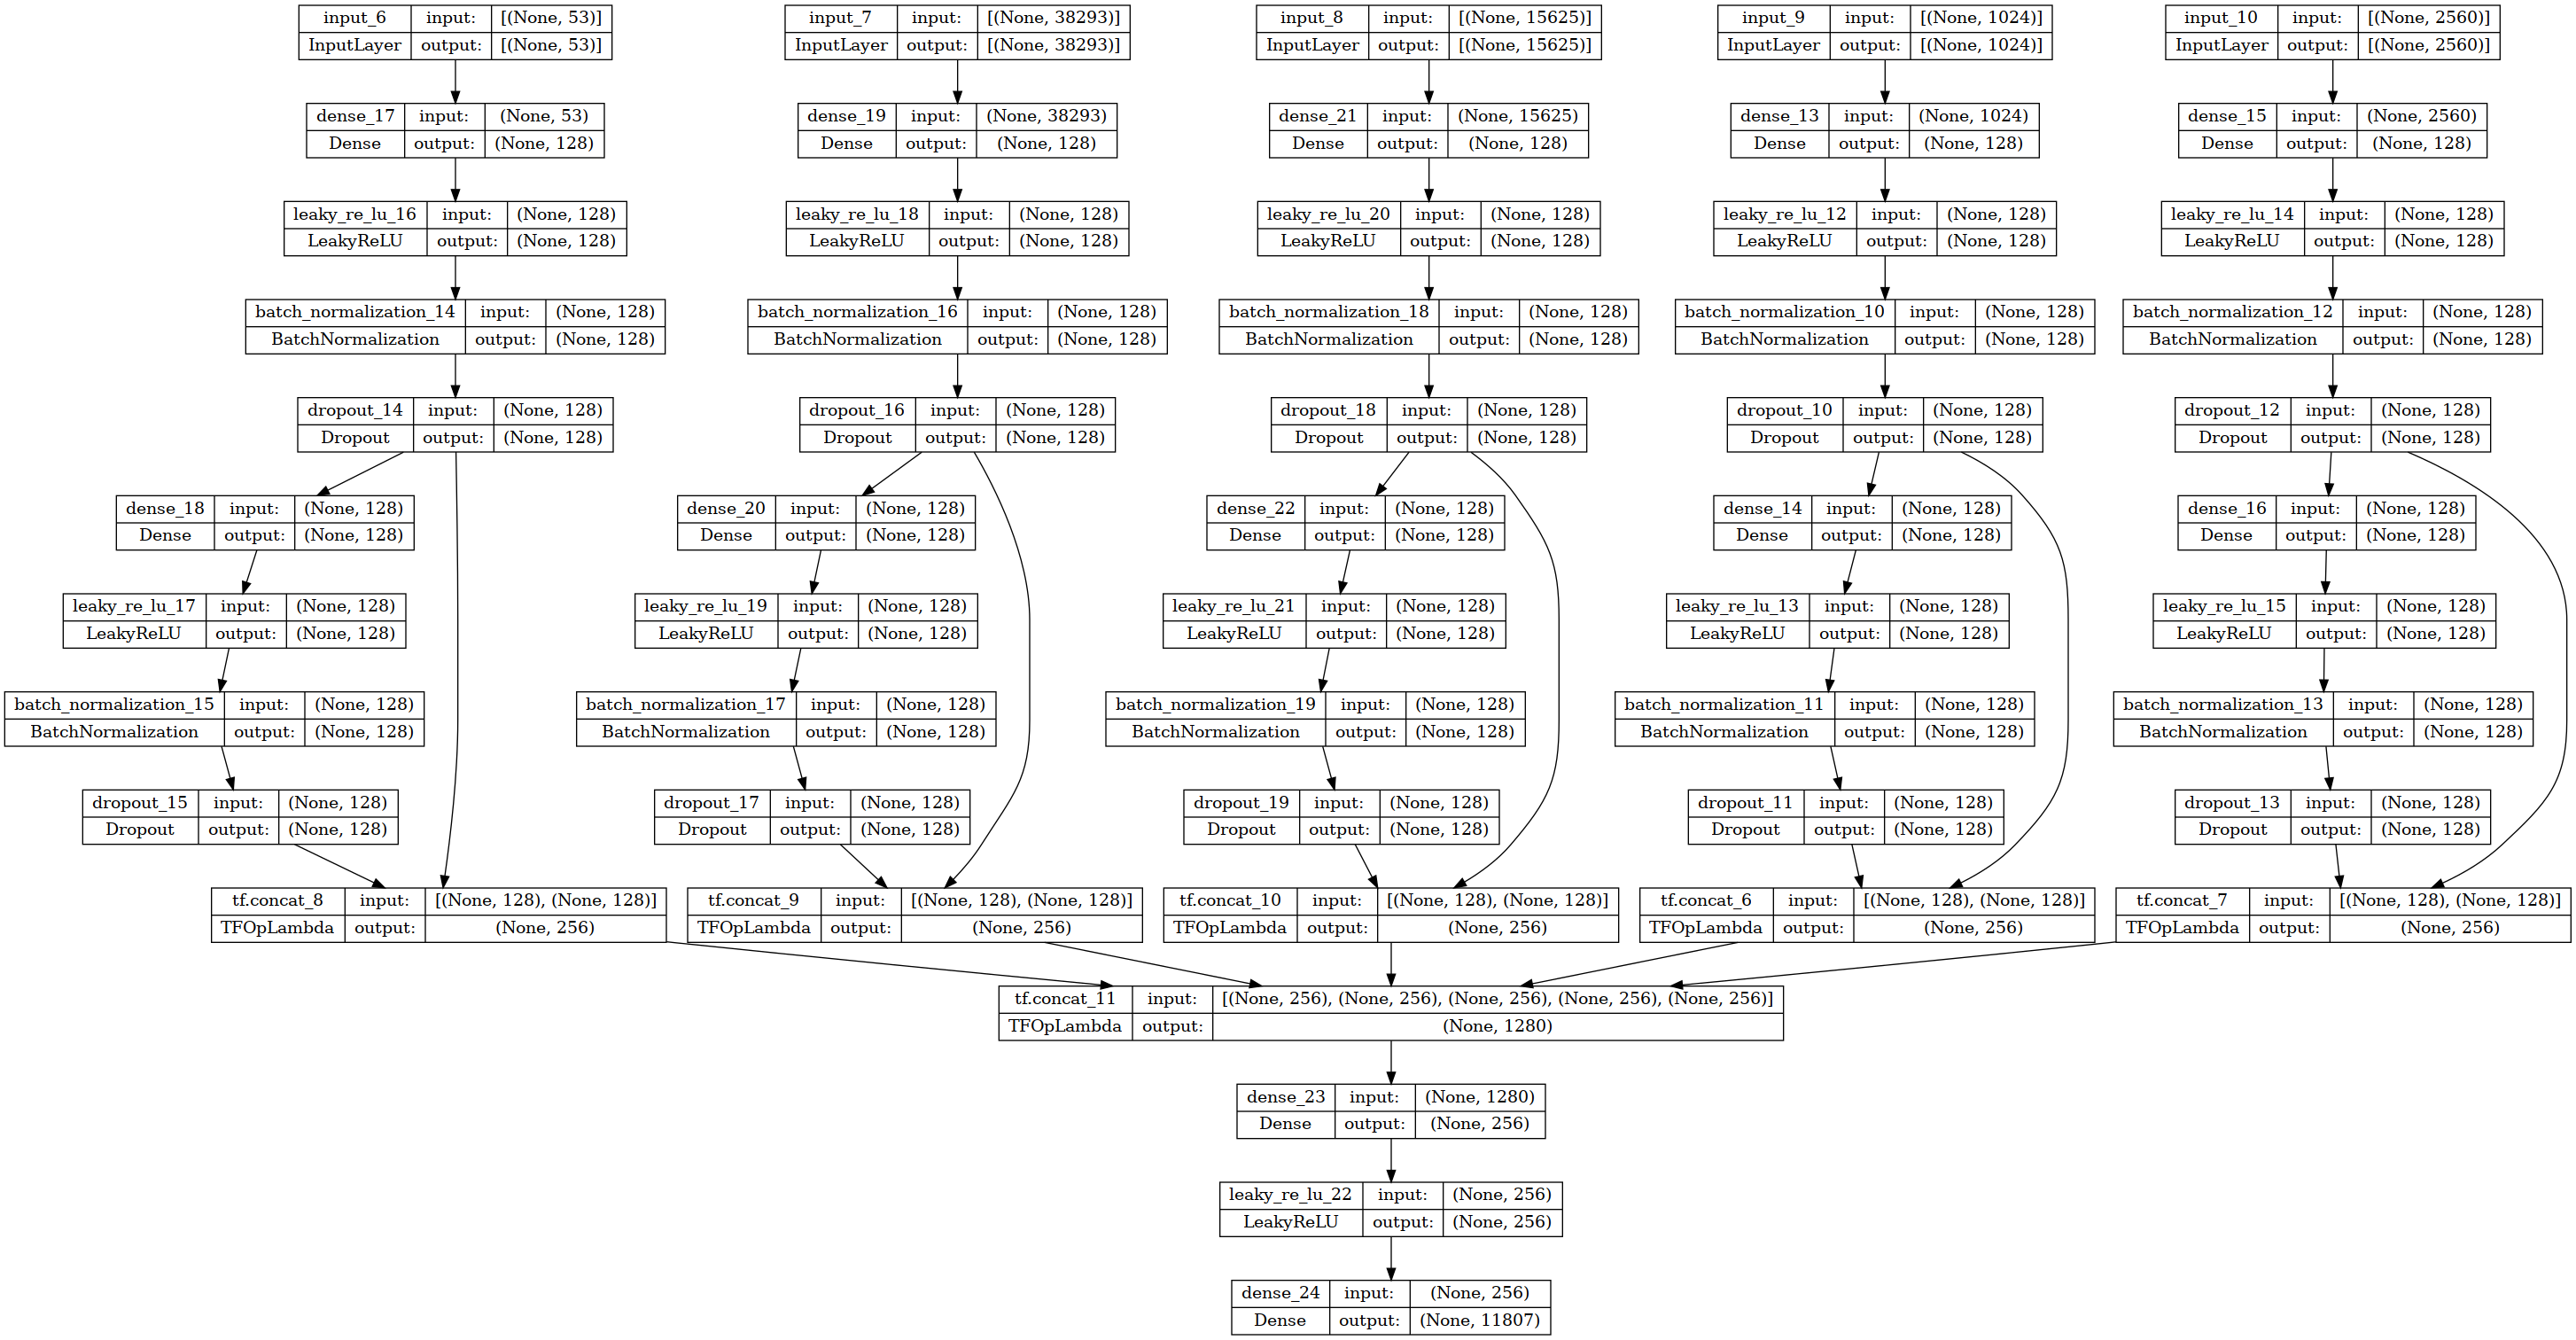

In [39]:
from tensorflow.keras import layers

VOCAB_SIZE=len(aa_dict)
EMBED_DIM=10

def createModel():
    inputsPC = tf.keras.Input(shape=(PCLength,))
    inputsIP = tf.keras.Input(shape=(len(mlbInterPro.classes_),))
    inputsKmer = tf.keras.Input(shape=(allCombinations.shape[0],))
    inputsT5 = tf.keras.Input(shape=(t5Dimension,))
    inputsEsm2 = tf.keras.Input(shape=(esm2Dimension,))
    
    # xT5 = layers.Attention()([inputsT5,inputsT5])
    xT5 = layers.Dense(128)(inputsT5)
    xT5 = layers.LeakyReLU()(xT5)
    xT5 = layers.BatchNormalization()(xT5)
    xT5Res = layers.Dropout(0.1)(xT5)
    xT5 = layers.Dense(128)(xT5Res)
    xT5 = layers.LeakyReLU()(xT5)
    xT5 = layers.BatchNormalization()(xT5)
    xT5 = layers.Dropout(0.1)(xT5)
    xT5 = tf.concat([xT5,xT5Res],1)

    xEsm2 = layers.Dense(128)(inputsEsm2)
    xEsm2 = layers.LeakyReLU()(xEsm2)
    xEsm2 = layers.BatchNormalization()(xEsm2)
    xEsm2Res = layers.Dropout(0.1)(xEsm2)
    xEsm2 = layers.Dense(128)(xEsm2Res)
    xEsm2 = layers.LeakyReLU()(xEsm2)
    xEsm2 = layers.BatchNormalization()(xEsm2)
    xEsm2 = layers.Dropout(0.1)(xEsm2)
    xEsm2 = tf.concat([xEsm2,xEsm2Res],1)

    # xPC = layers.Attention()([inputsPC,inputsPC])
    xPC = layers.Dense(128)(inputsPC)
    xPC = layers.LeakyReLU()(xPC)
    xPC = layers.BatchNormalization()(xPC)
    xPCRes = layers.Dropout(0.1)(xPC)
    xPC = layers.Dense(128)(xPCRes)
    xPC = layers.LeakyReLU()(xPC)
    xPC = layers.BatchNormalization()(xPC)
    xPC = layers.Dropout(0.1)(xPC)
    xPC = tf.concat([xPC,xPCRes],1)

    # xIP = layers.Attention()([inputsIP,inputsIP])
    xIP = layers.Dense(128)(inputsIP)
    xIP = layers.LeakyReLU()(xIP)
    xIP = layers.BatchNormalization()(xIP)
    xIPRes = layers.Dropout(0.1)(xIP)
    xIP = layers.Dense(128)(xIPRes)
    xIP = layers.LeakyReLU()(xIP)
    xIP = layers.BatchNormalization()(xIP)
    xIP = layers.Dropout(0.1)(xIP)
    xIP = tf.concat([xIP,xIPRes],1)

    # xKmer = layers.Attention()([inputsKmer,inputsKmer])
    xKmer = layers.Dense(128)(inputsKmer)
    xKmer = layers.LeakyReLU()(xKmer)
    xKmer = layers.BatchNormalization()(xKmer)
    xKmerRes = layers.Dropout(0.1)(xKmer)
    xKmer = layers.Dense(128)(xKmerRes)
    xKmer = layers.LeakyReLU()(xKmer)
    xKmer = layers.BatchNormalization()(xKmer)
    xKmer = layers.Dropout(0.1)(xKmer)
    xKmer = tf.concat([xKmer,xKmerRes],1)

    concat = tf.concat([xPC,xIP,xKmer,xT5, xEsm2],1)

    x = layers.Dense(256)(concat)
    x = layers.LeakyReLU()(x)

    outputs=layers.Dense(len(mlb.classes_), activation=tf.keras.activations.sigmoid)(x)

    return tf.keras.Model(inputs=[inputsPC, inputsIP, inputsKmer, inputsT5, inputsEsm2], outputs=outputs, name="DenseMultiModal5_Deep")

model = createModel()

model.summary()

dot_img_file = './model_1.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

In [36]:
import matplotlib.pyplot as plt
#Learning rate schedule
initial_learning_rate = 0.001
decaySteps=5000
lr_schedule = tf.keras.optimizers.schedules.CosineDecayRestarts(initial_learning_rate, first_decay_steps=decaySteps,
                                                                t_mul=1.7, m_mul=0.7)
# lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
#     initial_learning_rate, decay_steps=decaySteps, alpha=0.01)
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate,decay_steps=decaySteps,decay_rate=0.9,staircase=False)
# step = np.linspace(0,decaySteps*3)
# lr = lr_schedule(step)
# plt.figure(figsize = (8,6))
# # plt.yscale("log")
# plt.plot(step, lr)
# plt.ylim([0,max(plt.ylim())])
# plt.xlabel('step')
# _ = plt.ylabel('Learning Rate')

In [37]:
from utils import *

In [38]:

BATCH_SIZE=64
LOG_INTERVAL=20
epochs = 100
saveModel=True


log_dir = "./logs/"+model.name+"/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")+"_"+SO
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1,
                                                      write_graph=True, update_freq=5)


summary_writer = tf.summary.create_file_writer(log_dir)

# Instantiate an optimizer .
# optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)
# optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)
optimizer = tf.keras.optimizers.AdamW(learning_rate=3e-4)

# Instantiate a loss function.
# loss_fn = tf.keras.losses.BinaryCrossentropy()
# loss_fn = WeightedBinaryCE(np.ones(len(mlb.classes_)))
# loss_fn = WeightedBinaryCE(labelWeightsCorr)
# loss_fn = WeightedComboLoss(labelWeightsCorr, alpha=0.5, beta=0.5, labelSmoothing=0.05)
loss_fn = WeightedComboLoss(labelWeightsCorr/np.max(labelWeightsCorr)+occurenceScores, alpha=0.5, beta=0.5, labelSmoothing=0.1)
# loss_fn = tf.keras.losses.BinaryFocalCrossentropy(apply_class_balancing=True, gamma=2)

train_acc_metric = WeightedAccuracy(classWeights=labelWeightsCorr)
train_f1_metric = WeightedF1(classWeights=labelWeightsCorr, threshold=0.5)
train_prec = WeightedPrecision(classWeights=labelWeightsCorr)
train_rec = WeightedRecall(classWeights=labelWeightsCorr)

val_acc_metric = WeightedAccuracy(classWeights=labelWeightsCorr)
val_f1_metric = WeightedF1(classWeights=labelWeightsCorr, threshold=0.5)
val_prec = WeightedPrecision(classWeights=labelWeightsCorr)
val_rec = WeightedRecall(classWeights=labelWeightsCorr)

batchedDataset = dataset.batch(BATCH_SIZE, drop_remainder=False).prefetch(tf.data.AUTOTUNE)
batchedDatasetVal = datasetVal.batch(BATCH_SIZE, drop_remainder=False).prefetch(tf.data.AUTOTUNE)

# batchedDataset = batchedDataset.cache(os.path.join(DATA_PATH, "datasetCache"+SO))
# batchedDatasetVal = batchedDatasetVal.cache(os.path.join(DATA_PATH, "datasetCacheVal"+SO))

@tf.function()
def trainStep(x_batch_train, y_batch_train):
    with tf.GradientTape() as tape:
        probs = model(x_batch_train, training=True) 

        #Add all ancestor GOs based on the predictions
        # probsNew = tf.TensorArray(tf.float32, size=probs.shape[0])
        # for probsIdx in range(probs.shape[0]):
        #     predictedIdx = tf.where(tf.math.greater(probs[probsIdx], 0.5))
        #     predictedProbs = tf.gather_nd(probs[probsIdx], predictedIdx)
        #     # print(predictedIdx.numpy(), predictedProbs.numpy())
        #     vectToAdd = tf.TensorArray(tf.float32, size=predictedIdx.shape[0])
        #     for addingIdx, predIdx in enumerate(predictedIdx):
        #         ancestorsArr = ancestorDict[goIdxTensors[predIdx.numpy()[0]].ref()]
        #         vectToAdd.write(addingIdx, tf.math.multiply(tf.cast(ancestorsArr, tf.float32), predictedProbs[addingIdx])).mark_used()
        #     vectToAddTensors = vectToAdd.stack()
            # print(vectToAddTensors.numpy())
            # probsNew.write(probsIdx, tf.math.reduce_max(vectToAddTensors,axis=0)).mark_used()
        # probsNewTensor = probsNew.stack()
        
        loss_value = loss_fn(y_batch_train, probs)

    grads = tape.gradient(loss_value, model.trainable_weights)

    #Gradient clipping
    # grads = [tf.clip_by_norm(g, 2.0) for g in grads]

    train_acc_metric.update_state(y_batch_train, probs)
    train_f1_metric.update_state(y_batch_train, probs)
    train_prec.update_state(y_batch_train, probs)
    train_rec.update_state(y_batch_train, probs)

    optimizer.apply_gradients(zip(grads, model.trainable_weights)) 
    return loss_value

@tf.function()
def valStep(x_batch_val, y_batch_val):
    valProbs = model(x_batch_val, training=False)
    # Update val metrics
    val_acc_metric.update_state(y_batch_val, valProbs)
    val_f1_metric.update_state(y_batch_val, valProbs)
    val_prec.update_state(y_batch_val, valProbs)
    val_rec.update_state(y_batch_val, valProbs)

maxStep=0

for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch+1,))

    # Iterate over the batches of the dataset.
    for step, (x_batch_trainPC, x_batch_trainIP, x_batch_trainKmer, x_batch_trainT5, x_batch_trainEsm2, y_batch_train) in enumerate(batchedDataset):
        loss_value =trainStep((x_batch_trainPC, x_batch_trainIP, x_batch_trainKmer, x_batch_trainT5, x_batch_trainEsm2),y_batch_train)

        # Log 
        if step % LOG_INTERVAL == 0:
            template = 'Epoch {}/Step {}, Loss: {:.5f}, Accuracy: {:.5f}, F1: {:.4f}, Prec: {:.4f}, Rec: {:.4f}, lr: {:.5f}'
            print(template.format(epoch+1, step,loss_value.numpy(), 
                                    train_acc_metric.result(),train_f1_metric.result(),
                                    train_prec.result(), train_rec.result(), optimizer.learning_rate.numpy()))
            
            with summary_writer.as_default():
                tf.summary.scalar('loss', loss_value, step=maxStep*epoch+step)
                tf.summary.scalar('accuracy', train_acc_metric.result(), step=maxStep*epoch+step)
                tf.summary.scalar('f1', train_f1_metric.result(), step=maxStep*epoch+step)
                tf.summary.scalar('prec', train_prec.result(), step=maxStep*epoch+step)
                tf.summary.scalar('rec', train_rec.result(), step=maxStep*epoch+step)
                tf.summary.scalar('learning rate', optimizer.learning_rate.numpy(), step=maxStep*epoch+step)
                summary_writer.flush()

    
    train_acc_metric.reset_states()
    train_f1_metric.reset_states()
    train_prec.reset_states()
    train_rec.reset_states()

    maxStep=step

    print("Epoch finished. Start validation")
    for x_batch_valPC, x_batch_valIP, x_batch_valKmer, x_batch_valT5, x_batch_valEsm2, y_batch_val in batchedDatasetVal:
        valStep((x_batch_valPC, x_batch_valIP, x_batch_valKmer, x_batch_valT5, x_batch_valEsm2), y_batch_val)
    val_acc = val_acc_metric.result()
    val_acc_metric.reset_states()
    val_f1 = val_f1_metric.result()
    val_f1_metric.reset_states()
    val_precision = val_prec.result()
    val_prec.reset_states()
    val_recall = val_rec.result()
    val_rec.reset_states()
    print("Validation acc: %.4f" % (float(val_acc),))
    print("Validation f1: %.4f" % (float(val_f1),))
    print("Validation precision: %.4f" % (float(val_precision),))
    print("Validation recall: %.4f" % (float(val_recall),))
    with summary_writer.as_default():
        tf.summary.scalar('valAcc', float(val_acc), step=epoch)
        tf.summary.scalar('valF1', float(val_f1), step=epoch)
        tf.summary.scalar('valPrecision', float(val_precision), step=epoch)
        tf.summary.scalar('valRecall', float(val_recall), step=epoch)
        summary_writer.flush()
    if saveModel:
      model.save(os.path.join(DATA_PATH, "model_"+SO+"_epoch_{}_valF1Score{:.4f}".format(epoch, float(val_f1))))




Start of epoch 1


2023-08-12 10:50:46.952038: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fc6282eeb60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-08-12 10:50:46.952069: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1070, Compute Capability 6.1
2023-08-12 10:50:46.955251: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-08-12 10:50:47.063326: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-08-12 10:50:47.150194: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Epoch 1/Step 0, Loss: -0.00157, Accuracy: 0.49884, F1: 0.0026, Prec: 0.5216, Rec: 0.0013, lr: 0.00030
Epoch 1/Step 20, Loss: -0.00329, Accuracy: 0.57937, F1: 0.0049, Prec: 0.7150, Rec: 0.0024, lr: 0.00030
Epoch 1/Step 40, Loss: -0.05029, Accuracy: 0.74528, F1: 0.0230, Prec: 0.7188, Rec: 0.0120, lr: 0.00030
Epoch 1/Step 60, Loss: -0.07593, Accuracy: 0.82511, F1: 0.0528, Prec: 0.6600, Rec: 0.0291, lr: 0.00030
Epoch 1/Step 80, Loss: -0.07867, Accuracy: 0.86666, F1: 0.0771, Prec: 0.6084, Rec: 0.0445, lr: 0.00030
Epoch 1/Step 100, Loss: -0.10254, Accuracy: 0.89189, F1: 0.0969, Prec: 0.5705, Rec: 0.0580, lr: 0.00030
Epoch 1/Step 120, Loss: -0.10852, Accuracy: 0.90901, F1: 0.1109, Prec: 0.5393, Rec: 0.0683, lr: 0.00030
Epoch 1/Step 140, Loss: -0.10417, Accuracy: 0.92138, F1: 0.1232, Prec: 0.5126, Rec: 0.0782, lr: 0.00030
Epoch 1/Step 160, Loss: -0.12022, Accuracy: 0.93072, F1: 0.1331, Prec: 0.4902, Rec: 0.0866, lr: 0.00030
Epoch 1/Step 180, Loss: -0.09713, Accuracy: 0.93803, F1: 0.1414, Prec:

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_BPO_epoch_0_valF1Score0.2532/assets



Start of epoch 2
Epoch 2/Step 0, Loss: -0.13836, Accuracy: 0.99829, F1: 0.2492, Prec: 0.2442, Rec: 0.2543, lr: 0.00030
Epoch 2/Step 20, Loss: -0.13871, Accuracy: 0.99814, F1: 0.2566, Prec: 0.2428, Rec: 0.2736, lr: 0.00030
Epoch 2/Step 40, Loss: -0.14166, Accuracy: 0.99817, F1: 0.2560, Prec: 0.2412, Rec: 0.2745, lr: 0.00030
Epoch 2/Step 60, Loss: -0.14641, Accuracy: 0.99816, F1: 0.2552, Prec: 0.2388, Rec: 0.2757, lr: 0.00030
Epoch 2/Step 80, Loss: -0.13328, Accuracy: 0.99815, F1: 0.2541, Prec: 0.2380, Rec: 0.2748, lr: 0.00030
Epoch 2/Step 100, Loss: -0.14935, Accuracy: 0.99814, F1: 0.2543, Prec: 0.2373, Rec: 0.2761, lr: 0.00030
Epoch 2/Step 120, Loss: -0.14304, Accuracy: 0.99813, F1: 0.2536, Prec: 0.2362, Rec: 0.2760, lr: 0.00030
Epoch 2/Step 140, Loss: -0.13784, Accuracy: 0.99812, F1: 0.2533, Prec: 0.2356, Rec: 0.2762, lr: 0.00030
Epoch 2/Step 160, Loss: -0.14742, Accuracy: 0.99811, F1: 0.2538, Prec: 0.2364, Rec: 0.2761, lr: 0.00030
Epoch 2/Step 180, Loss: -0.11793, Accuracy: 0.99811,

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_BPO_epoch_1_valF1Score0.2562/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_BPO_epoch_1_valF1Score0.2562/assets



Start of epoch 3
Epoch 3/Step 0, Loss: -0.14016, Accuracy: 0.99828, F1: 0.2475, Prec: 0.2397, Rec: 0.2558, lr: 0.00030
Epoch 3/Step 20, Loss: -0.14223, Accuracy: 0.99815, F1: 0.2607, Prec: 0.2468, Rec: 0.2777, lr: 0.00030
Epoch 3/Step 40, Loss: -0.14878, Accuracy: 0.99816, F1: 0.2584, Prec: 0.2449, Rec: 0.2753, lr: 0.00030
Epoch 3/Step 60, Loss: -0.14532, Accuracy: 0.99816, F1: 0.2585, Prec: 0.2431, Rec: 0.2777, lr: 0.00030
Epoch 3/Step 80, Loss: -0.13458, Accuracy: 0.99816, F1: 0.2575, Prec: 0.2419, Rec: 0.2774, lr: 0.00030
Epoch 3/Step 100, Loss: -0.15109, Accuracy: 0.99814, F1: 0.2574, Prec: 0.2404, Rec: 0.2791, lr: 0.00030
Epoch 3/Step 120, Loss: -0.14732, Accuracy: 0.99814, F1: 0.2567, Prec: 0.2390, Rec: 0.2794, lr: 0.00030
Epoch 3/Step 140, Loss: -0.13982, Accuracy: 0.99813, F1: 0.2565, Prec: 0.2379, Rec: 0.2805, lr: 0.00030
Epoch 3/Step 160, Loss: -0.14890, Accuracy: 0.99813, F1: 0.2567, Prec: 0.2375, Rec: 0.2813, lr: 0.00030
Epoch 3/Step 180, Loss: -0.11607, Accuracy: 0.99813,

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_BPO_epoch_2_valF1Score0.2591/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_BPO_epoch_2_valF1Score0.2591/assets



Start of epoch 4
Epoch 4/Step 0, Loss: -0.14380, Accuracy: 0.99830, F1: 0.2590, Prec: 0.2527, Rec: 0.2655, lr: 0.00030
Epoch 4/Step 20, Loss: -0.13898, Accuracy: 0.99813, F1: 0.2618, Prec: 0.2499, Rec: 0.2765, lr: 0.00030
Epoch 4/Step 40, Loss: -0.14657, Accuracy: 0.99814, F1: 0.2595, Prec: 0.2480, Rec: 0.2739, lr: 0.00030
Epoch 4/Step 60, Loss: -0.14168, Accuracy: 0.99814, F1: 0.2604, Prec: 0.2472, Rec: 0.2766, lr: 0.00030
Epoch 4/Step 80, Loss: -0.13543, Accuracy: 0.99813, F1: 0.2590, Prec: 0.2456, Rec: 0.2760, lr: 0.00030
Epoch 4/Step 100, Loss: -0.15073, Accuracy: 0.99812, F1: 0.2589, Prec: 0.2444, Rec: 0.2772, lr: 0.00030
Epoch 4/Step 120, Loss: -0.14079, Accuracy: 0.99812, F1: 0.2580, Prec: 0.2427, Rec: 0.2775, lr: 0.00030
Epoch 4/Step 140, Loss: -0.13707, Accuracy: 0.99811, F1: 0.2576, Prec: 0.2410, Rec: 0.2789, lr: 0.00030
Epoch 4/Step 160, Loss: -0.14967, Accuracy: 0.99812, F1: 0.2581, Prec: 0.2406, Rec: 0.2805, lr: 0.00030
Epoch 4/Step 180, Loss: -0.11912, Accuracy: 0.99812,

KeyboardInterrupt: 

In [ ]:

# model.save(os.path.join(DATA_PATH, "model_"+SO+"_epoch_{}_valf1Score{:.3f}".format(epoch, float(val_f1))))

## Error analysis

Which GO classes are most misclassified? Is it correlated with the class imbalance?

In [ ]:
layerGOs={}
for layer, nodes in enumerate(networkx.topological_generations(graph)):
    # layerGOs[layer] = nodes
    for n in nodes:
        layerGOs[n] = layer


In [ ]:


tp=[]
fp=[]
fn=[]

predictionArr=[]
trueClassesArr=[]

for i, (xPC, xIP, xKmer,xt5, y) in enumerate(tqdm(batchedDatasetVal)):
    probsArr = model((xPC, xIP, xKmer, xt5), training=False)
    for idxProbs, probs in enumerate(probsArr):
        probs = probs.numpy()
        prediction= [1 if p > 0.5 else 0 for p in probs]
        predictionArr.append(probs)
        trueClassesArr.append(y[idxProbs,:])
        predClasses = mlb.inverse_transform(np.array([prediction]))[0]
        trueClasses = mlb.inverse_transform(np.array([y[idxProbs,:]]))[0]
        for pred in predClasses:
            if pred in trueClasses:
                tp.append(pred)
            else:
                fp.append(pred)
        for trueClass in trueClasses:
            if not trueClass in predClasses:
                fn.append(trueClass)
    
    if i>100:
        break

tpValues, tpCounts = np.unique(tp, return_counts=True)
fpValues, fpCounts = np.unique(fp, return_counts=True)
fnValues, fnCounts = np.unique(fn, return_counts=True)
    

### Find best threshold for f1 score

In [ ]:
predictionArr=np.array(predictionArr)
trueClassesArr=np.array(trueClassesArr)
print(trueClassesArr.shape)
print(predictionArr.shape)


thresholds=np.arange(0.00001, 0.001, 0.00003)
print(thresholds)
f1Values=[]

for t in thresholds:
    f1ThreshTest = WeightedF1(classWeights=labelWeightsCorr, threshold=t)
    f1ThreshTest.update_state(trueClassesArr, predictionArr)
    f1Value = f1ThreshTest.result()
    f1Values.append(f1Value.numpy())


In [ ]:
print("Best Threshold: ",thresholds[np.argmax(f1Values)])
plt.plot(thresholds, f1Values)

### Find GOs with highest tp, tn and tp rate

In [ ]:
for n in tpValues[tpCounts>600]:
    try:
        print(n, ": ", layerGOs[n])
    except:
        print("failed for ", n)
    
plt.figure(figsize=(12,6))
plt.bar(tpValues[tpCounts>600], tpCounts[tpCounts>600])
plt.xticks(rotation=90)
plt.title("True Positives")
plt.show()

plt.figure(figsize=(12,6))
plt.hist([layerGOs[tpVal] for tpVal in tpValues])
plt.xticks(rotation=45)
plt.title("Histogram of layer depth of True Positives")
plt.show()

plt.figure(figsize=(12,6))
plt.hist([occurenceDict[tpVal] for tpVal in tpValues], bins=50, range=(0,10000))
plt.xticks(rotation=45)
plt.title("Histogram of occurence count of True Positives")
plt.show()


In [ ]:
for n in fpValues[fpCounts > 200]:
    print(n, ": ", layerGOs[n])

plt.figure(figsize=(12, 6))
plt.bar(fpValues[fpCounts > 200], fpCounts[fpCounts > 200])
plt.xticks(rotation=90)
plt.title("False Positives")
plt.show()

plt.figure(figsize=(12, 6))
plt.hist([layerGOs[fpVal] for fpVal in fpValues[fpCounts > 10]])
plt.xticks(rotation=45)
plt.title("Histogram of layer depth of False Positives with more than 10 occurences")
plt.show()

plt.figure(figsize=(12, 6))
plt.hist([occurenceDict[fpVal] for fpVal in fpValues], bins=50, range=(0,10000))
plt.xticks(rotation=45)
plt.title(
    "Histogram of occurence counts of False Positives"
)
plt.show()

In [ ]:
for n in fnValues[fnCounts>200]:
    print(n, ": ", layerGOs[n])
    
plt.figure(figsize=(12,6))
plt.bar(fnValues[fnCounts>200], fnCounts[fnCounts>200])
plt.xticks(rotation=90)
plt.title("False Negatives")
plt.show()

plt.figure(figsize=(12,6))
plt.hist([layerGOs[fnVal] for fnVal in fnValues[fnCounts>10] ])
plt.xticks(rotation=45)
plt.title("Histogram of layer depth of False Negatives with more than 10 occurences")
plt.show()

plt.figure(figsize=(12,6))
plt.hist([occurenceDict[fnVal] for fnVal in fnValues], bins=50, range=(0,10000))
plt.xticks(rotation=45)
plt.title("Histogram of occurence count of False Negatives")
plt.show()


- The GO terms that are true positives most of the time are from different layers in the GO graph. There is no tendency that the model is better at classifying GOs at a higher layer, i.e. are more general.
- The GO terms that are true positive have different frequencies in the dataset. But there is a tendency that true positives are the less common GOs, which is not an expected behavior.
- The GO terms that are false positives or false negatives show a clear tendency to occur in a lower layer of the GO graph (which is more specific). But there are also some errors in the higher layers.
- The GO terms that are false positives or false negatives show a clear tendency to occur in the classes that are less common in the dataset. So this is an indicator that class imbalance is a problem here.